# **Deep Learning Homework 6: *Variational Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---

In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset. In developing the VAE we also explore how to develop an ad-hoc layer and a custom training step.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.


### Load Dataset
We load the MNIST dataset, using `tf.keras.datasets`. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits.

In [1]:
# load necessary libriaries and functions
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.subplot(1, 2, 1)
  plt.plot(history.epoch,history.history['reconstruction_loss'])
  plt.title('reconstruction_loss')
  plt.subplot(1, 2, 2)
  plt.plot(history.epoch,history.history['kl_loss'])
  plt.title('kl_loss')
  plt.show()

In [2]:
(x_train_full, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the pixel values
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Flatten the arrays
x_train = x_train_full.reshape((len(x_train_full), np.prod(x_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# In this HW, we will not need a validation set since we will not deal with model selection
# x_valid, y_valid = x_train[:10000], y_train[:10000]
# x_train, y_train = x_train[10000:], y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class `tf.keras.layers` that is used as base class for all the layers defined in Keras. In more detail, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[TO COMPLETE]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method, and make sure the output shape is the proper one.


In [3]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #[TO COMPLETE] compute and return z
        z_mean, z_var = inputs
        z = z_mean + tf.exp(z_var / 2) * tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the Encoder. Let's use $n$ dense layers (similarly to what we did in HW5, with a funnel-like architecture), and then use the obtained encoding to compute `z_mean` and `z_var`, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model `z_mean` and `z_var`. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. Insert motivations about your choice into the tex cell below.

In [4]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))
# x = ...[TO COMPLETE with more layers]...
x = tf.keras.layers.Dense(256, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim, activation="linear")(x) #[TO COMPLETE] Hint: size would be = latent_dim
z_var = tf.keras.layers.Dense(latent_dim, activation="linear")(x) #[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          32896       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           8256        ['dense_1[0][0]']                
                                                                                            

**Answer:** Motivations for the architectural choices:

__Number of layers:__ I chose to use 3 dense layers ($n$ = 3) because that number seems to be sufficient to let the model encode the most relevant information in the latent space

__Layers sizes:__ The choice of the layers sizes must be made in such a way as to allow the model to learn only the important features. The model shouldn't be too powerful, eventually learning useless features that it should have discarded instead.
Since the input size is 784 (28x28 images) and latent space dimensionality is 2, I figured out that a funnel structure (256 -> 128 -> 64) should be well suited for the task

__Activation function:__ I used the ReLU activation function as a baseline and since it performs quite well I keep it. I also tried the model with tanh activation but found no substantial differences in the final results.

__z_mean__ and __z_var:__ I choose the linear activation function for those two layers in order to not change the values that they receive in input

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. $n$ layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: Define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer). Answer in the text cell below.

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
#...[TO COMPLETE]...
x = tf.keras.layers.Dense(64, activation='relu')(latent_inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)

decoder_outputs = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_5 (Dense)             (None, 64)                192       
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 784)               201488    
                                                                 
Total params: 243,024
Trainable params: 243,024
Non-trainable params: 0
_________________________________________________________________


**Answer:** Motivations for the architectural choices:

__Decoder architecture:__ The architectural choices for the decoder (number of layers, layers sizes, activation functions) were largely based on the one taken for the encoder. Since the architecture of the decoder should be specular to the encoder architecture, i used $n$ = 3 layers of the same dimensions of the ones in the encoder, but occurring in the reverse order (64 -> 128 -> 256). I alse used the same activation function (ReLU) used in the encoder

__Last Layer activation function:__ As an activation function for the last layer I choose the sigmoid. The choice is motivated by the fact that our input (pixels values) were normalised and we want the output to end up in the same range, that is [0,1]. Obviously the sigmoid ranges between 0 and 1, exactly as we need

##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy (`keras.losses.binary_crossentropy`) to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: # record operations for automatic differentiation
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = tf.reduce_mean(data.shape[1] * tf.keras.losses.binary_crossentropy(data, reconstruction))

            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var)), axis=1))

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) # optimize the custom loss
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

Epoch 1/30
469/469 [==============================] - 6s 8ms/step - loss: 198.0673 - reconstruction_loss: 194.0464 - kl_loss: 4.0209
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 168.4516 - reconstruction_loss: 163.7497 - kl_loss: 4.7019
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 160.9363 - reconstruction_loss: 155.7616 - kl_loss: 5.1747
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 155.4073 - reconstruction_loss: 149.8313 - kl_loss: 5.5760
Epoch 5/30
469/469 [==============================] - 4s 8ms/step - loss: 151.8981 - reconstruction_loss: 146.1083 - kl_loss: 5.7898
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 149.5979 - reconstruction_loss: 143.6761 - kl_loss: 5.9218
Epoch 7/30
469/469 [==============================] - 2s 5ms/step - loss: 147.8752 - reconstruction_loss: 141.8247 - kl_loss: 6.0505
Epoch 8/30
469/469 [==============================] - 2s 5ms/step - l

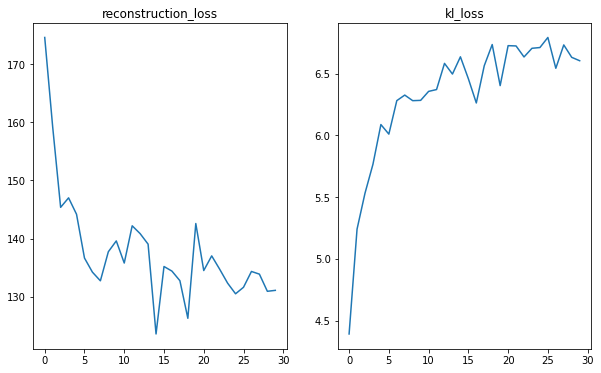

In [8]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)
plot_loss(history)

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

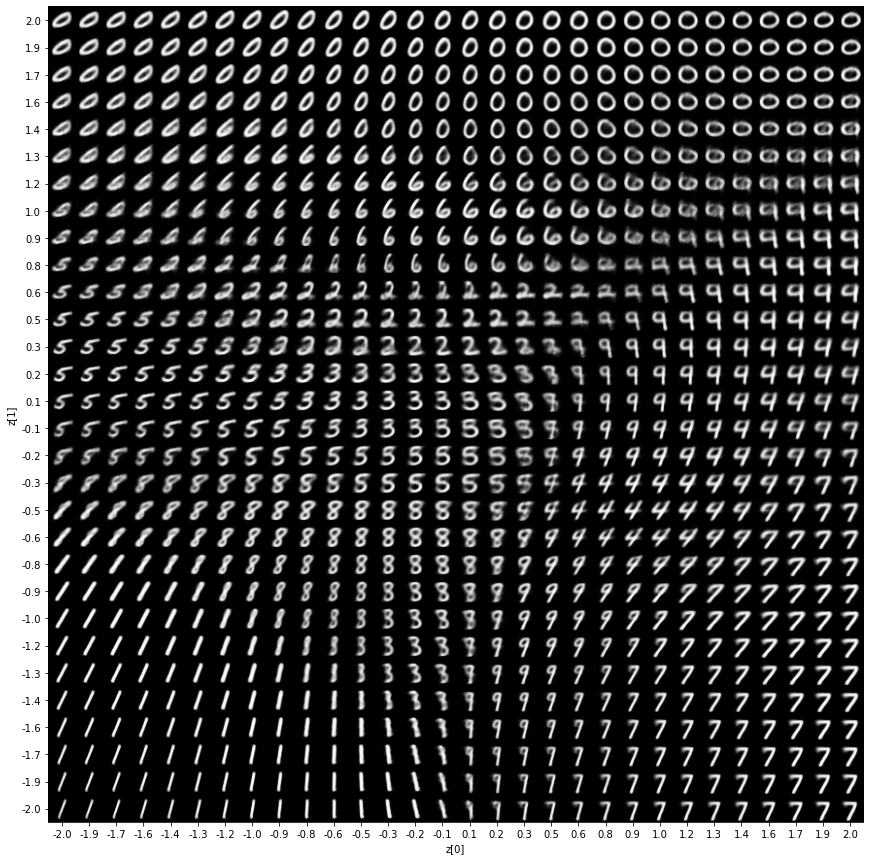

In [9]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2, 30) 

#[TO COMPLETE] explore what happens with different "scales"

[TO COMPLETE] __Explore what happens with different "scales"__

The __scale__ parameter define the interval from where the entries of $\hat{z}$ are chosen (to be used to generate new esamples by passing them to the decoder).  

With smaller __scale__ values the model reproduces fewer digits (only a subset of the 10 possible digits). Instead with higher values (and even with the default one (scale = 2)) the model is capable to reproduce more digits and in some cases to present at least a bounch of example for each different digit.  

The __scale__ parameter influences also the correctness and blurryness of the examples. With lower values the examples are more detailed and the obtained digits seems more realistics. With higher values the images become more blurryed and in some cases they even fail to represent actual digits. The failure in representing an actual digit may be due to the fact that the high __scale__ ends up exceeding the borders of the latent space.

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

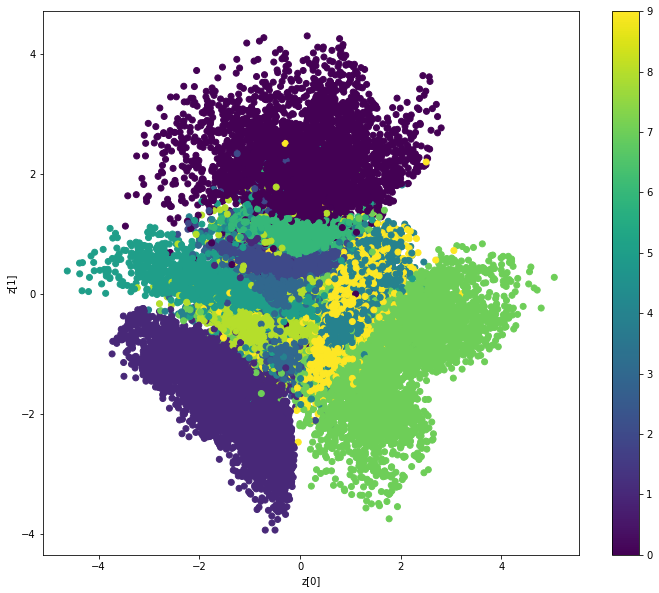

In [10]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

**Answer:** __Discussion about the obtained plots:__

The first plot (__plot_latent__) shows a grid of samples generated by the decoder. In this way is possible to have an illustration of the latent space (that has a 2D dimensionality). Through this illustration we can see how moving in the latent space results in different outputs and in particular in different digits. We can also see that tha model placed the encoding of digits with similar structure (for instance 8 and 3) close one to another in the latent space.  

The second plot (__plot_label_clusters__) shows an illustration of the encodings of the training examples in the latent space.  

By comparing the two plots we can notice a strong correlation.  
For instance the cluster of 1's in the second plot on the bottom-left, corresponding to the instances of the training set with associated the label 1, can be traced back in the first plot, again in the bottom-left of the grid, where are present newly generated examples that actually resembles 1's. 
This operation can be done for all the other digits.

We can examine the second plot in order to choose an appropriate value for the variable __scale__ of the first plot. The value scale should not exceed the area that is covered by training examples, otherwise we will end up with not meaningful reconstruction in the grid.  

We can also noticed that areas in which the training examples clusters are not well separated (where they overlap) corresponds to areas in the grid where the reconstructed images are blurry or they seem to be somewhere between two digits.

__Hyper-parameters infuence:__ I tried different combinations of the hyper-parameters, here I comment the obtained results:

* __Increased number of layers:__ By increasing the number of layers the model seems to be able to better separate some digits. We can see that through the clusters of the training instances in the latent space. But even with an higher number of layers the model still has some difficulties in separating certain digits. For instance clusters of the digits (0, 1, 6, 7) were well defined and separated from the rest of the points. Instead the remaining digits clusters were basically overlapped (2, 3, 5, 8, 9). We can motivate this phenomena by the fact that those problematic digits have some aspects that place them very close one to another (the digit 3 may resemble the digits 5 and 8, the digit 2 resemble the digit 5, and so on...)

* __Decreased number of layers:__ The clusters of the training instances in the latent space were less compacted (the points seemed to be more sparse) but the final result showed no significant signs of deterioration (the reconstruction were well constructed and basically indistinguishable from the other obtained with different models).

* __Different number of neurons:__ The results in changing the number of neurons resemble the ones obtained by changing the number of layers. By increasing them the model seems to be able to better separate some digits representation in the latent space (reducing the overlapping ones). Decresing the number of neurons makes the model less capable of separating well the instances and tend to increase the sparsity of the clusters. No significant differences were noticed in the final reconstructions results while using a reasonable number of units. The main difference, noticeble in the grid, was that in the overlapping areas the reconstructed digits appeard more blurred.

* __Activation function:__ I used the _tanh_ activation function insted of the ReLU, but it didn't seemed to apport any significant changes in the final results.